In [13]:
!pip -q install pyshp
!pip -q install influxdb
!pip -q install shapely
!pip -q install ipyleaflet
!pip -q install plotly

In [14]:
import shapefile
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
import numpy as np
import tarfile
import os
from six.moves import urllib
import json
from influxdb import DataFrameClient
from dotenv import load_dotenv
from shapely.geometry import Point, Polygon
from ipyleaflet import Map, GeoJSON, basemaps, Polyline, Heatmap
import requests
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde
from scipy import stats
%matplotlib inline

load_dotenv()

In [16]:
def rm_outside_polygon(res_pd_frame,polygon):
    res_pd_frame_1 = res_pd_frame[['lon','lat','sensor_id']]
    res_pd_frame_2 = res_pd_frame_1.reset_index()
    res_pd_frame_3 = res_pd_frame_2.drop(columns=['index'])
    res_pd_frame4 = res_pd_frame_3.drop_duplicates()
    res_pd_frame4["polygon1"] = res_pd_frame4.apply(lambda row: Polygon(poly).intersects(Point(row["lon"], row["lat"])), axis = 1)
    res_pd_frame5 = res_pd_frame4.drop(res_pd_frame4[res_pd_frame4["polygon1"]].index)
    res_pd_frame = res_pd_frame[~res_pd_frame.sensor_id.isin(res_pd_frame5.sensor_id)]     
    return res_pd_frame

In [20]:
#sf = shapefile.Reader("landkreise-in-germany.shp") # This is Göttingen
#s = sf.shape(0)

sf = shapefile.Reader("bundesland.shp") # Complete germany, 16 shapes for each bundesland
s = sf.shape(3) # Baden-Württemberg
poly = Polygon(s.points)  # Convert to polygon to use shapely function point.within(polygon)

geo_json = GeoJSON(data=s.__geo_interface__, style = {'color': 'red', 'opacity':1, 'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1})

In [21]:
def main(host=os.getenv("HOST"), port=os.getenv("PORT"), rectangle=[0,0,0,0],time_range=["",""],limit=100):
    """Instantiate the connection to the InfluxDB client."""
    user = os.getenv("USER")
    password = os.getenv("PASSWORD")
    dbname = os.getenv("DB")
    protocol = 'line'

    client = DataFrameClient(host, port, user, password, dbname, ssl=True, verify_ssl=True)

    bind_params = {
        "start_time_epoch": time_range[0],
        "end_time_epoch": time_range[1]
    }
    
    measurement = "P1, temperature, lat, lon, sensor_id"
    
    query = f"select {measurement} from sensor where \
                     time > $start_time_epoch AND \
                     time < $end_time_epoch AND \
                     lon > {rectangle[0]} AND \
                     lon < {rectangle[2]} AND \
                     lat > {rectangle[1]} AND \
                     lat < {rectangle[3]} \
                     limit {limit}"
                
    res=client.query(query, bind_params=bind_params)
    return res

In [22]:
m = Map(center=(48.7,9.8,0 ), zoom=8, basemap=basemaps.Hydda.Full)
m.add_layer(geo_json)

## Change the 'start_date' & 'date_to_end_query' for changing the time duration of query

In [23]:
start_date = datetime(2017, 1, 2)
end_date = start_date + timedelta(hours=1)

date_to_start_query = start_date
date_to_end_query = datetime(2017, 1, 3)

appended_res_pd_frame_plot_timeindex = []
appended_drop_P1 = []
appended_mean_P1_humi = []

j = 0
number = 5
while number >= 5:
    start_time = time.time()
    
    time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
    print(time_range)
    
    res_P1_humi=main(rectangle=s.bbox,time_range=time_range,limit=10000)
    
    if not res_P1_humi:
        print('Data empty in %s' %time_range)
        start_date=end_date
        end_date=start_date + timedelta(hours=1)
        
    if res_P1_humi:    
        res_pd_frame_P1_humi=rm_outside_polygon(res_P1_humi['sensor'],poly)
            
        res_pd_frame_P1_humi = res_pd_frame_P1_humi.drop([ 'lat', 'lon', 'sensor_id'], axis = 1)
        res_pd_frame_mean_P1_humi = res_pd_frame_P1_humi.mean(axis = 0, skipna = True)
        res_pd_frame_mean_P1_humi = res_pd_frame_mean_P1_humi.to_frame()
        res_pd_frame_mean_P1_humi = res_pd_frame_mean_P1_humi.swapaxes("index", "columns") 
        res_pd_frame_mean_P1_humi = res_pd_frame_mean_P1_humi.rename(index={0: start_date})

        appended_mean_P1_humi.append(res_pd_frame_mean_P1_humi)  


        start_date=end_date
        end_date=start_date + timedelta(hours=1)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    if start_date == date_to_end_query: # 7-2=5, 5 days, therefore the variable of k and j in the last cell should be 5
        break

appended_mean_P1_humi = pd.concat(appended_mean_P1_humi)
appended_mean_P1_humi

['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--- 1.5419509410858154 seconds ---
['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']
--- 1.5940306186676025 seconds ---
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
--- 1.4282112121582031 seconds ---
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
--- 1.5793097019195557 seconds ---
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
--- 1.4746289253234863 seconds ---
['2017-01-02T05:00:00Z', '2017-01-02T06:00:00Z']
--- 1.4570822715759277 seconds ---
['2017-01-02T06:00:00Z', '2017-01-02T07:00:00Z']
--- 1.443408727645874 seconds ---
['2017-01-02T07:00:00Z', '2017-01-02T08:00:00Z']
--- 1.4560017585754395 seconds ---
['2017-01-02T08:00:00Z', '2017-01-02T09:00:00Z']
--- 1.707411766052246 seconds ---
['2017-01-02T09:00:00Z', '2017-01-02T10:00:00Z']
--- 1.54087495803833 seconds ---
['2017-01-02T10:00:00Z', '2017-01-02T11:00:00Z']
--- 1.3880529403686523 seconds ---
['2017-01-02T11:00:00Z', '2017-01-02T12:00:00Z']
--- 1.4487309455871582 seconds ---
['2017-01-02T12:00:00Z', '2017-01-02T13:00:00

,P1,temperature
2017-01-02 00:00:00,1390.907851,-1.556795
2017-01-02 01:00:00,485.289026,-1.972844
2017-01-02 02:00:00,874.504325,-1.889298
2017-01-02 03:00:00,449.250815,-1.804539
2017-01-02 04:00:00,874.859992,-1.671390
...,...,...
2017-01-02 19:00:00,774.643935,1.390767
2017-01-02 20:00:00,916.718162,1.346831
2017-01-02 21:00:00,1005.864328,1.308699
2017-01-02 22:00:00,1034.373806,1.233799


In [24]:
pd.set_option('display.max_rows', 10)
appended_mean_P1_humi

,P1,temperature
2017-01-02 00:00:00,1390.907851,-1.556795
2017-01-02 01:00:00,485.289026,-1.972844
2017-01-02 02:00:00,874.504325,-1.889298
2017-01-02 03:00:00,449.250815,-1.804539
2017-01-02 04:00:00,874.859992,-1.671390
...,...,...
2017-01-02 19:00:00,774.643935,1.390767
2017-01-02 20:00:00,916.718162,1.346831
2017-01-02 21:00:00,1005.864328,1.308699
2017-01-02 22:00:00,1034.373806,1.233799


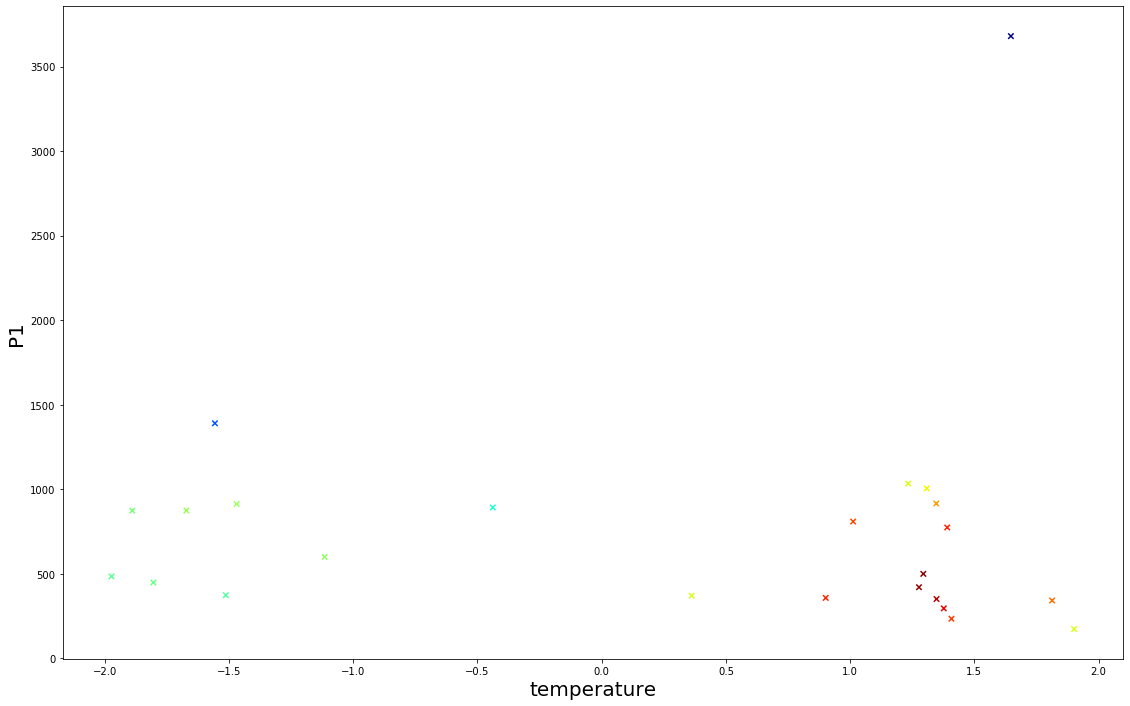

In [25]:
plt.rcParams["figure.figsize"] = (19, 12)
x = appended_mean_P1_humi.temperature
y = appended_mean_P1_humi.P1

# Calculate the point density 
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# Z-score (Standard Deviation)

In [26]:
P1_humi_drop_outliers = appended_mean_P1_humi[(np.abs(stats.zscore(appended_mean_P1_humi)) < 3).all(axis=1)]
P1_humi_drop_outliers

,P1,temperature
2017-01-02 00:00:00,1390.907851,-1.556795
2017-01-02 01:00:00,485.289026,-1.972844
2017-01-02 02:00:00,874.504325,-1.889298
2017-01-02 03:00:00,449.250815,-1.804539
2017-01-02 04:00:00,874.859992,-1.671390
...,...,...
2017-01-02 19:00:00,774.643935,1.390767
2017-01-02 20:00:00,916.718162,1.346831
2017-01-02 21:00:00,1005.864328,1.308699
2017-01-02 22:00:00,1034.373806,1.233799


In [27]:
z = np.abs(stats.zscore(appended_mean_P1_humi))
print(z)

[[0.93147502 1.28612096]
 [0.39573087 1.58097238]
 [0.17467339 1.52176392]
 [0.44854572 1.46169589]
 [0.17519463 1.36733388]
 [0.55884773 1.25497178]
 [0.2319609  1.2239001 ]
 [0.22684308 0.97283846]
 [0.20174344 0.49322954]
 [0.56319009 0.07366012]
 [0.58191768 0.4562536 ]
 [0.48936859 0.72224264]
 [0.6046711  1.10200091]
 [0.85287499 1.16459475]
 [4.28692958 0.98437113]
 [0.76249476 0.81484822]
 [0.59169318 0.77231424]
 [0.37376077 0.73453503]
 [0.67276821 0.79293097]
 [0.02832562 0.80280105]
 [0.23653878 0.77166334]
 [0.3671846  0.7446394 ]
 [0.40896591 0.69155854]
 [0.07971489 0.53441295]]


In [28]:
z.shape

(24, 2)

In [29]:
threshold = 3
print(np.where(z > 3))

(array([14]), array([0]))


In [30]:
print(z[1][0])

0.39573086630737314


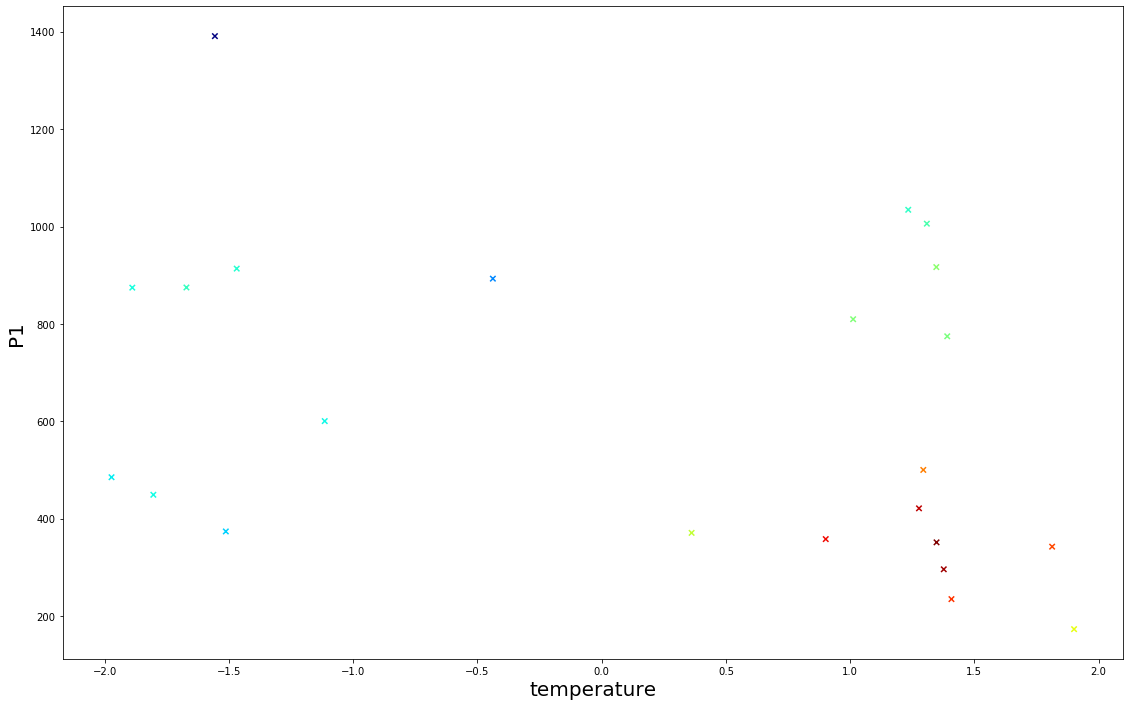

In [31]:
#plotting with z-score
plt.rcParams["figure.figsize"] = (19, 12)
x = P1_humi_drop_outliers.temperature
y = P1_humi_drop_outliers.P1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)
plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# IQR score, IQR = Q3 − Q1

In [32]:
Q1 = appended_mean_P1_humi.quantile(0.25)
Q3 = appended_mean_P1_humi.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

P1             530.301745
temperature      2.834981
dtype: float64


In [33]:
df = (appended_mean_P1_humi < (Q1 - 1.5 * IQR)) |(appended_mean_P1_humi > (Q3 + 1.5 * IQR))
df

,P1,temperature
2017-01-02 00:00:00,False,False
2017-01-02 01:00:00,False,False
2017-01-02 02:00:00,False,False
2017-01-02 03:00:00,False,False
2017-01-02 04:00:00,False,False
...,...,...
2017-01-02 19:00:00,False,False
2017-01-02 20:00:00,False,False
2017-01-02 21:00:00,False,False
2017-01-02 22:00:00,False,False


In [34]:
P1_humidity_rm_out = df[-df.P1]
P1_humidity_rm_out = P1_humidity_rm_out[-P1_humidity_rm_out.temperature]
P1_humidity_rm_out

,P1,temperature
2017-01-02 00:00:00,False,False
2017-01-02 01:00:00,False,False
2017-01-02 02:00:00,False,False
2017-01-02 03:00:00,False,False
2017-01-02 04:00:00,False,False
...,...,...
2017-01-02 19:00:00,False,False
2017-01-02 20:00:00,False,False
2017-01-02 21:00:00,False,False
2017-01-02 22:00:00,False,False


In [35]:
appended_mean_P1_humi_valid = appended_mean_P1_humi[~((appended_mean_P1_humi < (Q1 - 1.5 * IQR)) |(appended_mean_P1_humi > (Q3 + 1.5 * IQR))).any(axis=1)]
appended_mean_P1_humi_valid

,P1,temperature
2017-01-02 00:00:00,1390.907851,-1.556795
2017-01-02 01:00:00,485.289026,-1.972844
2017-01-02 02:00:00,874.504325,-1.889298
2017-01-02 03:00:00,449.250815,-1.804539
2017-01-02 04:00:00,874.859992,-1.671390
...,...,...
2017-01-02 19:00:00,774.643935,1.390767
2017-01-02 20:00:00,916.718162,1.346831
2017-01-02 21:00:00,1005.864328,1.308699
2017-01-02 22:00:00,1034.373806,1.233799


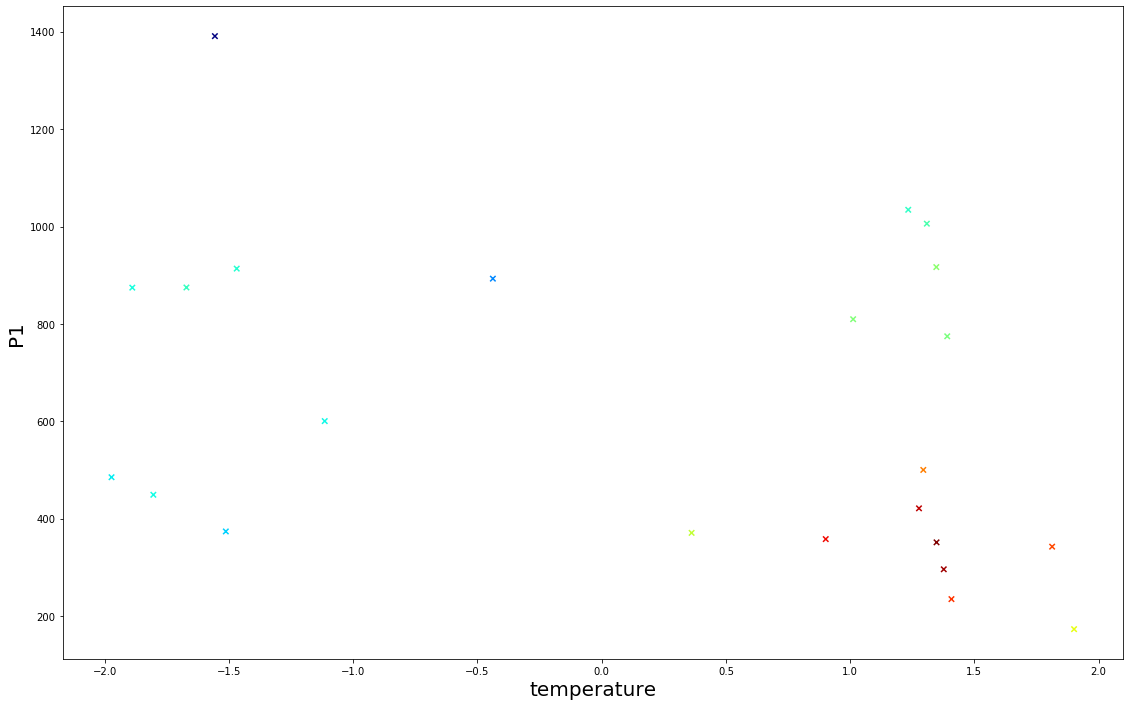

In [36]:
# plotting with IQR-score
plt.rcParams["figure.figsize"] = (19, 12)
x = appended_mean_P1_humi_valid.temperature
y = appended_mean_P1_humi_valid.P1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# Isolation forest

In [37]:
from sklearn.ensemble import IsolationForest

In [38]:
iso_forest = IsolationForest(n_estimators=300, contamination=0.10)
iso_forest = iso_forest.fit(appended_mean_P1_humi)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



In [39]:
isof_outliers = iso_forest.predict(appended_mean_P1_humi)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [40]:
isoF_non_outliers_values = appended_mean_P1_humi[iso_forest.predict(appended_mean_P1_humi) == 1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [41]:
isoF_outliers_values = appended_mean_P1_humi[iso_forest.predict(appended_mean_P1_humi) == -1]

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [42]:
isoF_outliers_values

,P1,temperature
2017-01-02 00:00:00,1390.907851,-1.556795
2017-01-02 13:00:00,173.356770,1.901274
2017-01-02 14:00:00,3680.501985,1.646971


In [43]:
isoF_non_outliers_values

,P1,temperature
2017-01-02 01:00:00,485.289026,-1.972844
2017-01-02 02:00:00,874.504325,-1.889298
2017-01-02 03:00:00,449.250815,-1.804539
2017-01-02 04:00:00,874.859992,-1.671390
2017-01-02 05:00:00,373.986246,-1.512842
...,...,...
2017-01-02 19:00:00,774.643935,1.390767
2017-01-02 20:00:00,916.718162,1.346831
2017-01-02 21:00:00,1005.864328,1.308699
2017-01-02 22:00:00,1034.373806,1.233799


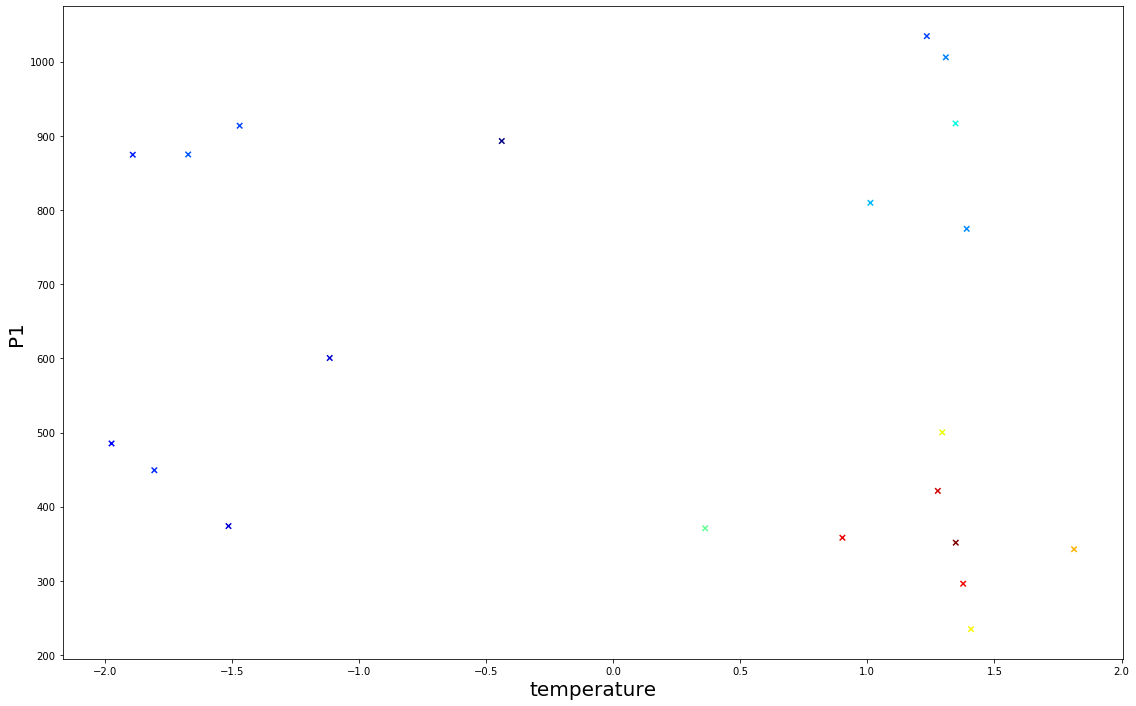

In [44]:
# plotting with isolation forest
plt.rcParams["figure.figsize"] = (19, 12)
x = isoF_non_outliers_values.temperature
y = isoF_non_outliers_values.P1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=30, edgecolor='',marker = "x", cmap=plt.cm.jet)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.xlabel('temperature', fontsize=20)
plt.ylabel('P1', fontsize=20)
plt.show()

# Correlation

In [45]:
isoF_non_outliers_values['P1'].corr(isoF_non_outliers_values['temperature'])

-0.1613205760747626

In [47]:
corrMatrix = isoF_non_outliers_values.corr()
print (corrMatrix)

                   P1  temperature
P1           1.000000    -0.161321
temperature -0.161321     1.000000
